In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("train.csv")

print(df.shape)
df.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [2]:
df.info()
df.describe()
df.isnull().sum()

df['Response'].value_counts(normalize=True) * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Response
0    87.743664
1    12.256336
Name: proportion, dtype: float64

In [3]:
df.columns = df.columns.str.strip()
df['Region_Code'] = df['Region_Code'].astype(str)
df['Vehicle_Age'] = df['Vehicle_Age'].astype(str).str.replace('> 2 Years', '>2') \
                                             .str.replace('< 1 Year', '<1') \
                                             .str.replace('1-2 Year', '1-2')

In [4]:
df['Driving_License'] = df['Driving_License'].fillna(0).astype(int)
df['Previously_Insured'] = df['Previously_Insured'].fillna(0).astype(int)

before = df.shape[0]
df.drop_duplicates(inplace=True)
print("Removed duplicates:", before - df.shape[0])

Removed duplicates: 0


In [5]:
df['Age_Group'] = pd.cut(df['Age'],
                         bins=[0,25,35,45,55,65,120],
                         labels=['<25','25-34','35-44','45-54','55-64','65+'])

df['Premium_Band'] = pd.qcut(df['Annual_Premium'], 4,
                             labels=['Low','Medium','High','Very High'])

df['Vintage_Bucket'] = pd.cut(df['Vintage'],
                              bins=[-1,90,365,730,9999],
                              labels=['<90 days','90-365 days','1-2 years','>2 years'])

df['Risk_Proxy'] = ((df['Annual_Premium'] > df['Annual_Premium'].quantile(0.75)).astype(int) +
                    (df['Vehicle_Damage'].astype(str).str.lower() == 'yes').astype(int) +
                    (df['Vintage'] < 90).astype(int))

In [6]:
df[['Age','Age_Group','Annual_Premium','Premium_Band',
    'Vintage','Vintage_Bucket','Risk_Proxy']].head()

,Age,Age_Group,Annual_Premium,Premium_Band,Vintage,Vintage_Bucket,Risk_Proxy
0,44,35-44,40454.0,Very High,217,90-365 days,2
1,76,65+,33536.0,High,183,90-365 days,0
2,47,45-54,38294.0,High,27,<90 days,2
3,21,<25,28619.0,Medium,203,90-365 days,0
4,29,25-34,27496.0,Medium,39,<90 days,1


In [7]:
df.to_csv("insurance_cleaned.csv", index=False)
print("File saved: insurance_cleaned.csv")

File saved: insurance_cleaned.csv


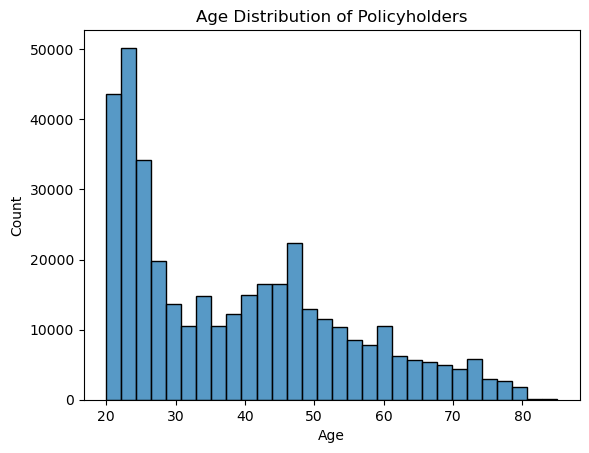

In [8]:
sns.histplot(df['Age'], bins=30, kde=False)
plt.title('Age Distribution of Policyholders')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_36320\3217108923.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_resp = df.groupby('Age_Group')['Response'].mean().reset_index()


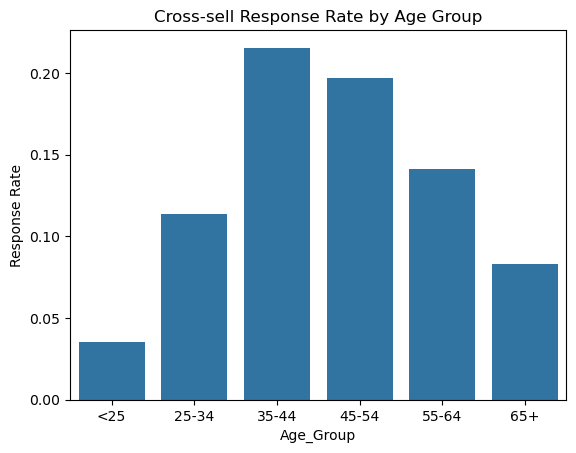

In [9]:
age_resp = df.groupby('Age_Group')['Response'].mean().reset_index()

sns.barplot(x='Age_Group', y='Response', data=age_resp, order=age_resp['Age_Group'])
plt.title('Cross-sell Response Rate by Age Group')
plt.ylabel('Response Rate')
plt.show()


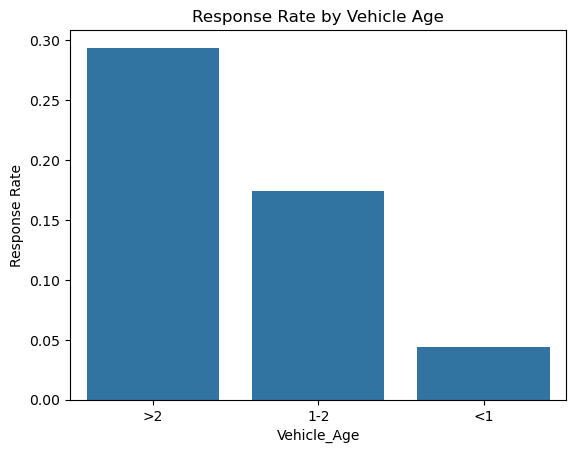

In [10]:
veh_resp = df.groupby('Vehicle_Age')['Response'].mean().reset_index().sort_values('Response', ascending=False)

sns.barplot(x='Vehicle_Age', y='Response', data=veh_resp, order=veh_resp['Vehicle_Age'])
plt.title('Response Rate by Vehicle Age')
plt.ylabel('Response Rate')
plt.show()

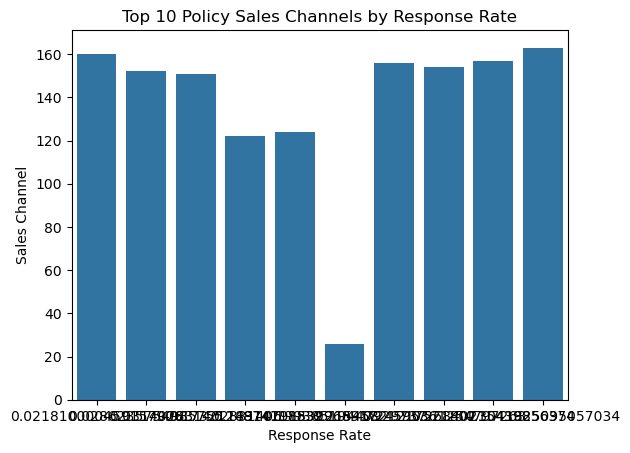

In [11]:
top_channels = df['Policy_Sales_Channel'].value_counts().head(10).index
channel_resp = df[df['Policy_Sales_Channel'].isin(top_channels)].groupby('Policy_Sales_Channel')['Response'].mean().reset_index()

sns.barplot(x='Response', y='Policy_Sales_Channel', data=channel_resp)
plt.title('Top 10 Policy Sales Channels by Response Rate')
plt.xlabel('Response Rate')
plt.ylabel('Sales Channel')
plt.show()

### Key Business Insights – Health Insurance Cross-Sell Analysis

1. **Age Distribution:**  
   Most customers fall between **30–50 years**, indicating the active policyholder base is middle-aged.

2. **Response Rate by Age Group:**  
   Cross-sell likelihood is **highest among 35–54 age group**. Younger and older groups show less interest.

3. **Response Rate by Vehicle Age:**  
   Customers owning **newer vehicles (<1 year)** have a higher response rate — indicating interest in new policy coverage.

4. **Top 10 Policy Sales Channels:**  
   A few sales channels drive much higher conversions. These can be prioritized for marketing and resource allocation.

**Overall Insight:**  
   - Only ~12% of customers show interest (Response=1), so focus campaigns on the **35–54 age group**, **new vehicle owners**, and **high-performing sales channels**.  
   - Recommend running targeted cross-sell campaigns via these top channels for better ROI.


In [13]:
df.to_csv("final_cleaned_insurance.csv", index=False)
print("✅ Exported file: final_cleaned_insurance.csv")

✅ Exported file: final_cleaned_insurance.csv
